# Playground Self Supervised Learning: Fashionset Classification (FashionMNIST Dataset)

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import resnet101, resnet18, vgg19
import matplotlib.pyplot as plt
import PIL
from random import randint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = 'img/'

target_size = (256, 256)
transforms = Compose([
    Resize(target_size),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

images = ImageFolder(root_dir, transform=transforms)

In [6]:
print(images)

Dataset ImageFolder
    Number of datapoints: 289219
    Root Location: img/
    Transforms (if any): Compose(
                             Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
0


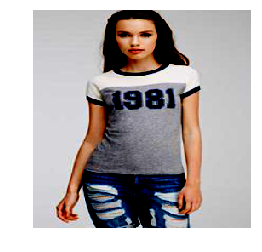

In [38]:
image = PIL.Image.open('img/2-in-1_Space_Dye_Athletic_Tank/img_00000001.jpg')
plt.imshow((images[0][0]).permute(1, 2, 0))
plt.axis('off');

image, label = images[0]
print(image.size())
print(label)

In [31]:
list_category_img = pd.read_csv('list_category_img.txt', sep="\t", header=0)
list_category_img.columns = ["image_name", "category_label"]

list_category_cloth = pd.read_csv('list_category_cloth.txt', sep="\t", header=0)
list_category_cloth.columns = ["category_name", "category_type"]

list_eval_partition = pd.read_csv('list_eval_partition.txt', sep="\t", header=0)
list_eval_partition.columns = ["image_name", "evaluation_status"]

In [32]:
list_category_img.head()

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [33]:
list_category_cloth.head()

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1


In [34]:
list_eval_partition.head()

,image_name,evaluation_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [39]:
print(list_category_img.image_name[0])
print(list_category_img.category_label[0])

print(list_category_cloth.category_name[0])
print(list_category_cloth.category_type[0])

print(list_eval_partition.image_name[0])
print(list_eval_partition.evaluation_status[0])

img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
3
Anorak 
1
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


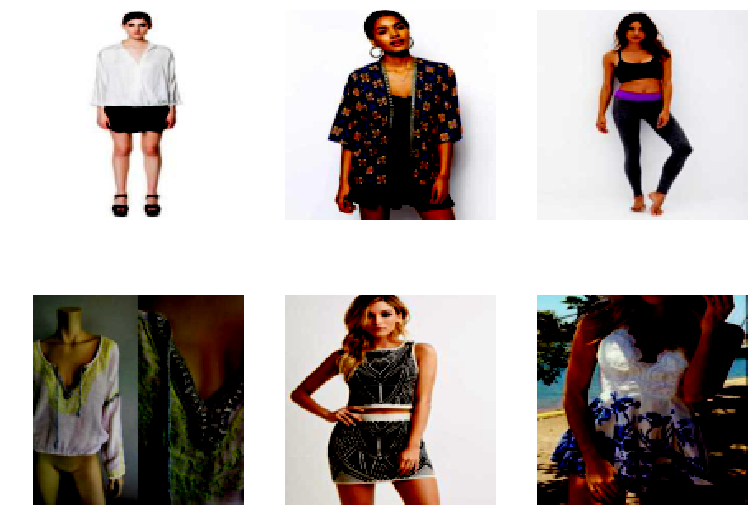

In [8]:
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(images))
    axes[i].imshow(images[index][0].permute(1, 2, 0))
    axes[i].axis('off')

## 2. Set aside data for validation and testing

In [ ]:
train_set, val_set, test_set = [], [], []
train_labels, val_labels, test_labels = [], [], []

for i in range(len(images)):
    if list_eval_partition.evaluation_status[i] == 'train':
        train_set.append(images[i])
        train_labels.append(list_category_img.category_label[i])
        
    if list_eval_partition.evaluation_status[i] == 'val':
        val_set.append(images[i])
        val_labels.append(list_category_img.category_label[i])   
    
    if list_eval_partition.evaluation_status[i] == 'test':
        test_set.append(images[i])
        test_labels.append(list_category_img.category_label[i])

## Load Data

In [10]:
from torch.utils.data import DataLoader
dataloader = DataLoader(images, batch_size=32, shuffle=True, num_workers=4)

In [11]:
#We can iterate over the dataset
for xs, ys in dataloader:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])
tensor([ 240,  852,  173, 5455, 4104, 1280, 5421, 1388,  192, 2174, 2829,  949,
         359, 4234, 4120, 1096, 1142, 1013,  250, 1876,  807, 3007,  839, 1789,
        5119, 1910,  183, 3991, 2698, 4429,  256, 5571])


## Models

In [49]:
import copy

def train(model, loss_fn, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        scheduler.step()
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(images)
        epoch_acc = running_corrects.double() / len(images)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # deep copy the model
        # if phase == 'valid' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())

    print()
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [53]:
model_resnet18 = resnet18(pretrained=False)
model_resnet18.avgpool = nn.AdaptiveAvgPool2d((1,1))
model_resnet18.fc = nn.Linear(16 * 32, 50)

In [54]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=10

In [55]:
model_ft = train(model_resnet18, loss_fn, optim, sched, eps)

Epoch 1/10
torch.Size([32, 3, 128, 128])


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:93